In [37]:
import os
import tempfile


import requests
from osgeo import gdal
import xarray as xr
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import s3fs

fs = s3fs.S3FileSystem(anon=False)

os.chdir("/home/brandon.taylor/precip-merging/")

s3_bucket = "metstormlive-v2-intermediate-prd"

# Read StageIV data locally 

In [29]:
from datetime import datetime, timedelta
w = -130.3
s = 20.25
e = -49.9
n = 59

stage_four_data = {}
hours = [int(x) for x in range(24)]
hours = [17]

date = "20220310"

zulu_time = datetime.utcnow() - timedelta(hours=6)

for hour in hours:
    remote_url = (
        f"https://mesonet.agron.iastate.edu/archive/data/{zulu_time:%Y}/{zulu_time:%m}/"
        f"{zulu_time:%d}/stage4/ST4.{zulu_time:%Y%m%d%H}.01h.grib"
    )
    print(remote_url)
    fname = f"stageiv/ST4.{zulu_time:%Y%m%d%H}.01h.grib"
    data = requests.get(remote_url)
    with open(fname, 'wb')as f:
        f.write(data.content)
    nc_fname = fname.replace("grib", "nc")

    warp_options = gdal.WarpOptions(dstSRS="EPSG:4326",
                                    outputBounds=[w, s, e, n], format="netCDF",
                                    width=8040, height=3875)
    ds = gdal.Warp(nc_fname, fname, options=warp_options)
    ds = None
    ds = xr.load_dataset(nc_fname)
    ds.Band1.values = np.nan_to_num(ds.Band1.values)
    ds = ds.rename_vars({"Band1": "Stage4Hourly"})
    stage_four_data.update({hour: ds["Stage4Hourly"].values})
    print(ds.Stage4Hourly.max(), ds.Stage4Hourly.min())

https://mesonet.agron.iastate.edu/archive/data/2022/03/14/stage4/ST4.2022031409.01h.grib
<xarray.DataArray 'Stage4Hourly' ()>
array(4.625) <xarray.DataArray 'Stage4Hourly' ()>
array(0.)


# Read TYP data from s3

In [6]:
typ_data = {}

for hour in hours:
    s3_remote_key = (f"{s3_bucket}/preprocessed/{date}_{hour:02d}/CC_TYP_{date}_{hour:02d}00_001hr.nc")
    with fs.open(s3_remote_key) as f:
        typ = xr.open_dataset(f, chunks="auto")
        typ_data.update({hour: typ["qpftype"].values})
        print(typ["qpftype"].max(), typ["qpftype"].min())

<xarray.DataArray 'qpftype' ()>
dask.array<_nanmax_skip-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray> <xarray.DataArray 'qpftype' ()>
dask.array<_nanmin_skip-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


# Read QPF data from s3


In [7]:
qpf_data = {}
ds_name = "QPF"
fs.invalidate_cache()
for hour in hours:
    s3_remote_key = (f"{s3_bucket}/preprocessed/{date}_{hour:02d}/CC_{ds_name}_{date}_{hour:02d}00_001hr.nc")
    with tempfile.NamedTemporaryFile() as s3_tmpfile:
        fs.get_file(s3_remote_key, s3_tmpfile.name)
        qpf = xr.open_dataset(s3_tmpfile.name, engine="h5netcdf")
        qpf_data.update({hour: qpf["qpf60min"].values})
        print(qpf["qpf60min"].max(), qpf["qpf60min"].min())


<xarray.DataArray 'qpf60min' ()>
array(6.7749) <xarray.DataArray 'qpf60min' ()>
array(0.)


# Read GHE data from s3


In [8]:
ghe_data = {}
ds_name = "GHE"

for hour in hours:
    s3_remote_key = (f"{s3_bucket}/preprocessed/{date}_{hour:02d}/CC_{ds_name}_{date}_{hour:02d}00_001hr.nc")
    with tempfile.NamedTemporaryFile() as s3_tmpfile:
        fs.get_file(s3_remote_key, s3_tmpfile.name)
        ghe = xr.open_dataset(s3_tmpfile.name, engine="h5netcdf")
        ghe_data.update({hour: ghe["ghe60min"].values})
        print(ghe["ghe60min"].max(), ghe["ghe60min"].min())


<xarray.DataArray 'ghe60min' ()>
array(16.20867399) <xarray.DataArray 'ghe60min' ()>
array(0.)


# Read PPR data from s3


In [9]:
ppr_data = {}
ds_name = "PPR"

for hour in hours:
    s3_remote_key = (f"{s3_bucket}/preprocessed/{date}_{hour:02d}/CC_{ds_name}_{date}_{hour:02d}00_001hr.nc")
    with tempfile.NamedTemporaryFile() as s3_tmpfile:
        fs.get_file(s3_remote_key, s3_tmpfile.name)
        ppr = xr.open_dataset(s3_tmpfile.name, engine="h5netcdf")
        pad_ppr = np.pad(ppr["HourlyPolarimetricPrecipAccum"].values, ((0,0),(0,10)), 'constant', constant_values=np.nan)
        ppr_data.update({hour: pad_ppr})
        print(ppr["HourlyPolarimetricPrecipAccum"].max(), ppr["HourlyPolarimetricPrecipAccum"].min())


<xarray.DataArray 'HourlyPolarimetricPrecipAccum' ()>
array(72.2) <xarray.DataArray 'HourlyPolarimetricPrecipAccum' ()>
array(0.)


# Read Z2P data from s3


In [10]:
z2p_data = {}
ds_name = "Z2P"
for hour in hours:
    s3_remote_key = (f"{s3_bucket}/preprocessed/{date}_{hour:02d}/CC_{ds_name}_{date}_{hour:02d}00_001hr.nc")
    with tempfile.NamedTemporaryFile() as s3_tmpfile:
        try:
            fs.get_file(s3_remote_key, s3_tmpfile.name)
            z2p = xr.open_dataset(s3_tmpfile.name, engine="h5netcdf")
            pad_z2p = np.pad(z2p["Precipitation_from_Lowalt"].values, ((0,0),(0,10)), 'constant', constant_values=np.nan)
            z2p_data.update({hour: pad_z2p[:-1, :]})
            print(z2p["Precipitation_from_Lowalt"].max(), z2p["Precipitation_from_Lowalt"].min())
        except:
            print("z2p missing")
            z2p_empty = np.empty((3875, 8040))
            z2p_empty[:] = np.nan
            z2p_data.update({hour: z2p_empty})



/opt/userenvs/brandon.taylor/metstormlive2-preprocessing/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.DataArray 'Precipitation_from_Lowalt' ()>
array(40.2831, dtype=float32) <xarray.DataArray 'Precipitation_from_Lowalt' ()>
array(0., dtype=float32)


# Read PER data from s3


In [8]:
per_data = {}
ds_name = "PER"
for hour in hours:
    s3_remote_key = (f"{s3_bucket}/preprocessed/{date}_{hour:02d}/CC_{ds_name}_{date}_{hour:02d}00_001hr.nc")
    with tempfile.NamedTemporaryFile() as s3_tmpfile:
        fs.get_file(s3_remote_key, s3_tmpfile.name)
        per = xr.open_dataset(s3_tmpfile.name, engine="h5netcdf")
        per_data.update({hour: per["persiann-qpe60min"][:, :-13].values})
        print(per["persiann-qpe60min"].max(), per["persiann-qpe60min"].min())


<xarray.DataArray 'persiann-qpe60min' ()>
array(39.8082, dtype=float32) <xarray.DataArray 'persiann-qpe60min' ()>
array(0., dtype=float32)
<xarray.DataArray 'persiann-qpe60min' ()>
array(74.944305, dtype=float32) <xarray.DataArray 'persiann-qpe60min' ()>
array(0., dtype=float32)
<xarray.DataArray 'persiann-qpe60min' ()>
array(38.602654, dtype=float32) <xarray.DataArray 'persiann-qpe60min' ()>
array(0., dtype=float32)
<xarray.DataArray 'persiann-qpe60min' ()>
array(39.56064, dtype=float32) <xarray.DataArray 'persiann-qpe60min' ()>
array(0., dtype=float32)
<xarray.DataArray 'persiann-qpe60min' ()>
array(78.89337, dtype=float32) <xarray.DataArray 'persiann-qpe60min' ()>
array(0., dtype=float32)
<xarray.DataArray 'persiann-qpe60min' ()>
array(79.83, dtype=float32) <xarray.DataArray 'persiann-qpe60min' ()>
array(0., dtype=float32)
<xarray.DataArray 'persiann-qpe60min' ()>
array(38.418854, dtype=float32) <xarray.DataArray 'persiann-qpe60min' ()>
array(0., dtype=float32)
<xarray.DataArray 'pe

# Read MSK data from s3


In [11]:
msk_data = {}
ds_name = "MSK"
for hour in hours:
    s3_remote_key = (f"{s3_bucket}/preprocessed/{date}_{hour:02d}/CC_{ds_name}_{date}_{hour:02d}00_001hr.nc")
    with tempfile.NamedTemporaryFile() as s3_tmpfile:
        fs.get_file(s3_remote_key, s3_tmpfile.name)
        msk = xr.open_dataset(s3_tmpfile.name, engine="h5netcdf")
        msk_data.update({hour: msk["probprecip60min"][:-1, :-1].values})
        print(msk["probprecip60min"].max(), msk["probprecip60min"].min())

<xarray.DataArray 'probprecip60min' ()>
array(0.95112336, dtype=float32) <xarray.DataArray 'probprecip60min' ()>
array(0., dtype=float32)


In [14]:
import matplotlib.pyplot as plt
import pandas as pd


def assemble_data(hours):
    ppr_vector = np.array([])
    qpf_vector = np.array([])
    ghe_vector = np.array([])
    typ_vector = np.array([])
    z2p_vector = np.array([])
    msk_vector = np.array([])
    stage_four_vector = np.array([])
    for hour in hours:
        ppr_vector = np.concatenate([ppr_vector, ppr_data[hour].flatten()])
        qpf_vector = np.concatenate([qpf_vector, qpf_data[hour].flatten()])
        ghe_vector = np.concatenate([ghe_vector, ghe_data[hour].flatten()])
        typ_vector = np.concatenate([typ_vector, typ_data[hour].flatten()])
        z2p_vector = np.concatenate([z2p_vector, z2p_data[hour].flatten()])
        msk_vector = np.concatenate([msk_vector, msk_data[hour].flatten()])
        stage_four_vector = np.concatenate([stage_four_vector, stage_four_data[hour].flatten()])
    
    stacked = np.hstack((ppr_vector[:, None], 
                         qpf_vector[:, None],
                         ghe_vector[:, None],
                         typ_vector[:, None],
                         z2p_vector[:, None],
                         msk_vector[:, None],
                         stage_four_vector[:, None],
                        ))
    
    df = pd.DataFrame(stacked, columns = ["PPR", "QPF", "GHE", "TYP", "Z2P", "MSK", "ST4"])

    return df

In [ ]:
print(ppr_data[19].shape)
print(ghe_data[19].shape) 
print(qpf_data[19].shape)
print(typ_data[19].shape)
print(z2p_data[19].shape)
#print(per_data[19].shape) 
print(msk_data[19].shape)


def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 10])
    plt.xlabel("Epoch")
    plt.ylabel("Error [ST4]")
    plt.legend()
    plt.grid(True)

#plt.scatter(ppr_train_X, stage_four_train_labels)
#plt.show()

train_hours = [int(x) for x in range(24)]
train_hours.pop(17)
train_dataset = assemble_data(train_hours)

print(len(train_dataset))

print(train_dataset.describe().transpose()[["mean", "std"]])

train_dataset = train_dataset.loc[~(train_dataset==0).all(axis=1)]
print("drop all zero rows", len(train_dataset))
train_dataset = train_dataset.loc[~(train_dataset["QPF"]==0)]
print("drop zero QPF rows", len(train_dataset))
train_dataset = train_dataset.dropna()
print("drop invalid rows", len(train_dataset))

print(train_dataset.describe().transpose()[["mean", "std"]])

train_features = train_dataset.copy()
train_labels = train_features.pop("ST4")
normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_features))

716565000
         mean       std
PPR  0.032420  0.343670
QPF  0.078678  0.288029
GHE  0.058297  0.332112
TYP  2.178791  2.072124
Z2P  0.036838  0.372477
MSK  0.315424  0.306231
ST4  0.018621  0.283482
drop all zero rows 716565000
drop zero QPF rows 404266232
drop invalid rows 114003804
         mean       std
PPR  0.122483  0.656445
QPF  0.155402  0.353363
GHE  0.105952  0.429660
TYP  2.541442  2.646308
Z2P  0.077882  0.539691
MSK  0.399204  0.302491
ST4  0.071996  0.528576


2022-03-11 20:56:04.719110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-11 20:56:04.719621: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-11 20:56:04.719648: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0a02c1acab05): /proc/driver/nvidia/version does not exist
2022-03-11 20:56:04.723102: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
print(train_dataset.dropna())
print(train_dataset)

In [ ]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
      norm,
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(1)
    ])

    model.compile(loss="mean_absolute_error",
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

dnn_model = build_and_compile_model(normalizer)
                                    
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=50
)
dnn_model.save("dnn_regression_v10")

In [33]:
#dnn_model = tf.keras.models.load_model("dnn_regression_v1.10")
dnn_model = tf.keras.models.load_model("dnn_regression_v1.10.h5")
dnn_model.summary()
#dnn_model.save("dnn_regression_v1.10.h5")

ValueError: All `axis` values to be kept must have known shape. Got axis: (-1,), input shape: [None, None], with unknown axis at index: 1

In [15]:
#plot_loss(history)
test_dataset_all = assemble_data([17])

print(len(test_dataset_all))

#print(test_dataset.describe().transpose()[["mean", "std"]])

test_dataset_all_zero = test_dataset_all.loc[(test_dataset_all==0).all(axis=1)]
test_dataset_qpf_zero = test_dataset_all.loc[(test_dataset_all["QPF"]==0)]
print(len(test_dataset_all_zero), len(test_dataset_qpf_zero))

test_dataset = test_dataset_all.loc[~(test_dataset_all==0).all(axis=1)]
test_dataset = test_dataset_all.loc[~(test_dataset_all["QPF"]==0)]
print(len(test_dataset))
#train_dataset = train_dataset.dropna()

print(test_dataset.describe().transpose()[["mean", "std"]])


test_features = test_dataset.copy()
test_labels = test_features.pop("ST4")
#dnn_model.evaluate(test_features, test_labels, verbose=1)

31155000
0 13733117
17421883
         mean       std
PPR  0.043620  0.435752
QPF  0.133031  0.421025
GHE  0.084438  0.398694
TYP  2.339532  2.411895
Z2P  0.076369  0.744350
MSK  0.411722  0.270862
ST4  0.030377  0.434460


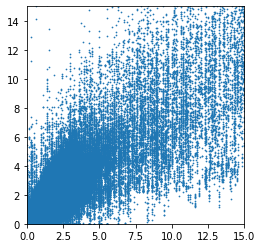

In [16]:
%matplotlib inline

test_predictions = dnn_model.predict(test_features).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions, s=0.5)
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
plt.show()
#dnn_model.save("dnn_regression_v7")

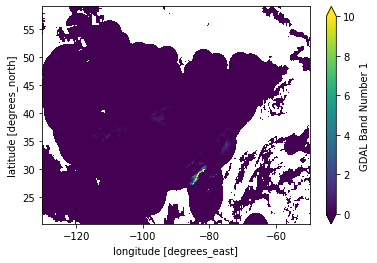

In [18]:
%matplotlib inline

test_dataset_all["Predicted_QPE"] = test_dataset_all["ST4"].copy()
test_dataset_all.loc[(test_dataset_all["QPF"]==0), "Predicted_QPE"] = 0
test_dataset_all.loc[~(test_dataset_all["QPF"]==0), "Predicted_QPE"] = test_predictions

ds["Stage4Hourly"].values = test_dataset_all["Predicted_QPE"].to_numpy().reshape((3875, 8040))
ds["Stage4Hourly"].plot(vmin=0, vmax=10)

ds.to_netcdf("dnn_test10.nc")

98.92235565185547
95.34568117268785


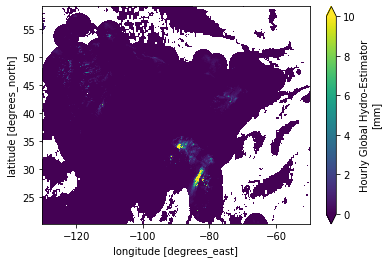

In [4]:
import xarray as xr
import numpy as np

dnn = xr.load_dataset("CC_DNN_20220316_0100_001hr.nc")
beq = xr.load_dataset("CC_BEQ_20220316_0100_001hr.nc")

print(np.nanmax(dnn["DNN_QPE_Prediction"].values))
dnn_beq = dnn["DNN_QPE_Prediction"].values + beq["second_guess"].values
blended_qpe = dnn_beq / 2.0
print(np.nanmax(blended_qpe))

dnn["DNN_QPE_Prediction"].values = blended_qpe
dnn.to_netcdf("CC_BLEND_20220316_0100_001hr.nc")
dnn["DNN_QPE_Prediction"].plot(vmin=0, vmax=10)

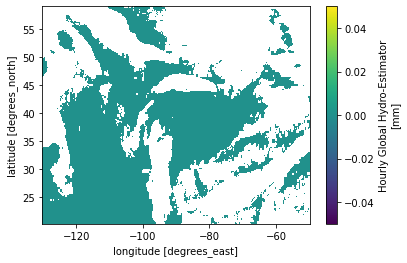

In [36]:
%matplotlib inline
ds["DNN_QPE_Prediction"].plot()

In [31]:
ds

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
            ..
31154995   NaN
31154996   NaN
31154997   NaN
31154998   NaN
31154999   NaN
Name: Predicted_QPE, Length: 31155000, dtype: float64

In [ ]:
%matplotlib widget

ppr_data = {}
ds_name = "PPR"

#for hour in [hours[0]]:
#    s3_remote_key = (f"{s3_bucket}/preprocessed/{date}_{hour:02d}/CC_{ds_name}_{date}_{hour:02d}00_001hr.nc")
#    with fs.open(s3_remote_key) as f:
#        ppr_actual = xr.load_dataset(f, chunks="auto")
ppr["Predicted_QPE"] = ppr["HourlyPolarimetricPrecipAccum"].copy(deep=True)
ppr["Predicted_QPE"].values = test_dataset_all["Predicted_QPE"].to_numpy().reshape((3875, 8030))

#ppr["Predicted_QPE"].values[ppr["Predicted_QPE"].values == 0] = np.nan
#ppr["HourlyPolarimetricPrecipAccum"].values[ppr["HourlyPolarimetricPrecipAccum"].values == 0] = np.nan


fig, axes = plt.subplots(ncols=2, figsize=(12, 8))
ppr["Predicted_QPE"].plot(ax=axes[0], vmin=0, vmax=10)
ppr["HourlyPolarimetricPrecipAccum"].plot(ax=axes[1], vmin=0, vmax=10)

#model.fit(train_dataset, epochs=10)

#%matplotlib widget

#ds.Stage4Hourly.plot(vmin=0, vmax=40)

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

#ppr_test_X = ppr_reshaped_test[~np.all(ppr_reshaped_test == 0, axis=(1, 2))]
probs = probability_model(ppr_test)
#print(probs.numpy()[:, 9].shape)
#probs_np = probs.numpy().max(axis=1)
#plt.scatter(range(probs.numpy()[:, 9].shape[0]), probs.numpy()[:, 9])
#plt.scatter(range(probs.numpy().max(axis=1).shape[0]), probs.numpy().max(axis=1))
#plt.show()
probs_np = probs.numpy().argmax(axis=1) / 10
plt.scatter(range(probs_np.shape[0]), probs_np)
plt.show()

In [ ]:
%matplotlib widget
#ppr_reshaped_train * probs_np
#print(np.broadcast_arrays(probs_np, ppr_reshaped_train))
#print(np.broadcast_to(probs_np, ppr_reshaped_train.shape))
probs_broadcast = ppr_test * probs_np[:, np.newaxis, np.newaxis]
probs_gridded = probs_broadcast.reshape((3875, 8030))
ppr["HourlyPolarimetricPrecipAccum"].values = probs_gridded
#np.tensordot(probs_np,ppr_reshaped_train, axes=([0],[0]))
#ppr["HourlyPolarimetricPrecipAccum"].plot(vmax=40)
ppr.to_netcdf("dnn_test5.nc")

In [ ]:
#comp = dict(zlib=True, complevel=4)
#encoding = {var: comp for var in ds.data_vars}
#ppr_train_X = ppr_reshaped[~np.all(ppr_reshaped == 0, axis=(1, 2))]

#ds.to_netcdf(nc_fname, encoding=encoding)

In [ ]:
ppr